# Libraries

In [59]:
from nequip.ase import NequIPCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import UnitCellFilter 
from ase.constraints import FixAtoms
from ase.io import Trajectory
import pickle
from ase.atoms import Atoms, units 
import numpy as np 
import json, os
from ase.optimize import LBFGS 
from pymatgen.core import Structure 

class TrajectoryObserver:
    """Trajectory observer is a hook in the relaxation process that saves the
    intermediate structures.
    """

    # thanks to CHGNet and M3GNET teams

    def __init__(self, atoms: Atoms) -> None:
        """Create a TrajectoryObserver from an Atoms object.

        Args:
            atoms (Atoms): the structure to observe.
        """
        self.atoms = atoms
        self.energies: list[float] = []
        self.forces: list[np.ndarray] = []
        #self.stresses: list[np.ndarray] = []
        #self.magmoms: list[np.ndarray] = []
        self.atom_positions: list[np.ndarray] = []
        self.cells: list[np.ndarray] = []

    def __call__(self) -> None:
        """The logic for saving the properties of an Atoms during the relaxation."""
        self.energies.append(self.compute_energy())
        self.forces.append(self.atoms.get_forces())
        #self.stresses.append(self.atoms.get_stress())
        #self.magmoms.append(self.atoms.get_magnetic_moments())
        self.atom_positions.append(self.atoms.get_positions())
        self.cells.append(self.atoms.get_cell()[:])

    def __len__(self) -> int:
        """The number of steps in the trajectory."""
        return len(self.energies)

    def compute_energy(self) -> float:
        """Calculate the potential energy.

        Returns:
            energy (float): the potential energy.
        """
        return self.atoms.get_potential_energy()

    def save(self, filename: str) -> None:
        """Save the trajectory to file.

        Args:
            filename (str): filename to save the trajectory
        """
        out_pkl = {
            "energy": self.energies,
            "forces": self.forces,
            #"stresses": self.stresses,
            #"magmoms": self.magmoms,
            "atom_positions": self.atom_positions,
            "cell": self.cells,
            "atomic_number": self.atoms.get_atomic_numbers(),
        }
        with open(filename, "wb") as file:
            pickle.dump(out_pkl, file)


def allegro_relaxer(atoms, potential_path, species, device='cpu', fmax = 0.01, steps = 250, verbose=False, relax_cell=True, loginterval=1):
    atoms.calc = NequIPCalculator.from_deployed_model(
        model_path=potential_path,
        species_to_type_name = species
    )
    
    if relax_cell:
        ucf = UnitCellFilter(atoms)
        obs = TrajectoryObserver(ucf)
        optimizer = LBFGS(ucf)
        optimizer.attach(obs, interval=loginterval)
        
    else:
        constraints = FixAtoms(mask=[False] * len(atoms))  # Allow all atoms to move
        # Add constraints to atoms
        atoms.set_constraint(constraints)

        obs = TrajectoryObserver(atoms)
        optimizer = LBFGS(atoms)
        optimizer.attach(obs, interval=loginterval)
    
    optimizer.run(fmax=fmax, steps=steps)
    struct = AseAtomsAdaptor.get_structure(atoms)
    return {"final_structure" : struct, "trajectory" : obs}

def numeric_stress(atoms, d=1e-6, voigt=True):
    stress = np.zeros((3, 3), dtype=float)

    cell = atoms.cell.copy()
    V = atoms.get_volume()
    for i in range(3):
        x = np.eye(3)
        x[i, i] += d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eplus = atoms.get_potential_energy(force_consistent=True)

        x[i, i] -= 2 * d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eminus = atoms.get_potential_energy(force_consistent=True)

        stress[i, i] = (eplus - eminus) / (2 * d * V)
        x[i, i] += d

        j = i - 2
        x[i, j] = d
        x[j, i] = d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eplus = atoms.get_potential_energy(force_consistent=True)

        x[i, j] = -d
        x[j, i] = -d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eminus = atoms.get_potential_energy(force_consistent=True)

        stress[i, j] = (eplus - eminus) / (4 * d * V)
        stress[j, i] = stress[i, j]
    atoms.set_cell(cell, scale_atoms=True)

    if voigt:
        return stress.flat[[0, 4, 8, 5, 2, 1]]
    else:
        return stress

def np_numeric_stress(atoms, d=1e-6, voigt=True):
    stress = np.zeros((3, 3), dtype=float)
    cell = atoms.cell.copy()
    V = atoms.get_volume()

    for i in range(3):
        x = np.eye(3)
        x[i, i] += d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eplus = atoms.get_potential_energy(force_consistent=True)
        
        x[i, i] -= 2 * d
        atoms.set_cell(np.dot(cell, x), scale_atoms=True)
        eminus = atoms.get_potential_energy(force_consistent=True)
        
        stress[i, i] = (eplus - eminus) / (2 * d * V)
        x[i, i] += d
        
        for j in range(i + 1, 3):
            x[i, j] = d
            x[j, i] = d
            atoms.set_cell(np.dot(cell, x), scale_atoms=True)
            eplus = atoms.get_potential_energy(force_consistent=True)
            
            x[i, j] = -d
            x[j, i] = -d
            atoms.set_cell(np.dot(cell, x), scale_atoms=True)
            eminus = atoms.get_potential_energy(force_consistent=True)
            
            stress[i, j] = (eplus - eminus) / (4 * d * V)
            stress[j, i] = stress[i, j]
    
    atoms.set_cell(cell, scale_atoms=True)

    return stress

# Run Code

In [3]:
# test the relaxing function
#load all the structures
# on pc
data_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/gen_0_4/Vacancies/converted_vcrtiwzr_gen_0_4_vacancies_data.json'
# on mac 
#data_path = '../Visualization/Job_Structures/Post_VASP/VCrTiWZr_Summit/Vacancies/converted_vcrtiwzr_gen_0_4_vacancies_data.json'
data = json.load(open(data_path, 'r'))

In [4]:
species = {
            "Ti": "NequIPTypeNameForTitanium",
            "V": "NequIPTypeNameForVanadium",
            "Cr" : "NequIPTypeNameForChromium",
            "Zr" : "NequIPTypeNameForZirconium",
            "W" : "NequIPTypeNameForTungsten",
        }

species = {"Ti" : "Ti", "V" : "V", "Cr" : "Cr", "Zr" : "Zr", "W" : "W"}

In [10]:
# get a structure 
structure = Structure.from_dict(data['supercell_gen0_comp11_struct3_vac_site3_start']['structures'][-1])
test_energy = data['supercell_gen0_comp11_struct3_vac_site3_start']['energies'][-1]
test_forces = data['supercell_gen0_comp11_struct3_vac_site3_start']['forces'][-1] 
test_stress = np.array(data['supercell_gen0_comp11_struct3_vac_site3_start']['stresses'][-1])

atoms = AseAtomsAdaptor.get_atoms(structure)

In [20]:
from pymatgen.core import Structure, Lattice
from pymatgen.io.vasp.inputs import Poscar 

# Lattice parameter
a = 3.01

# Rhombohedral lattice vectors for the primitive cell of a BCC lattice
lattice_vectors = [
    [0.5 * a, 0.5 * a, -0.5 * a],
    [0.5 * a, -0.5 * a, 0.5 * a],
    [-0.5 * a, 0.5 * a, 0.5 * a],
]

# Create the lattice
lattice = Lattice(lattice_vectors)

# Define the species and position for the single Vanadium atom in the primitive cell
species = ["V"]
position = [0, 0, 0]  # At the origin

# Create the structure
structure = Structure(lattice, species, [position])
for i in range(3,8):
    supercell = structure.copy()
    supercell.make_supercell([i, i, i])
    poscar = Poscar(supercell)
    poscar.write_file(f"new_POSCAR_{i*i*i}_atoms")


In [11]:
kb_to_ev_ang_3 = 6.242e-4
test_virial = -1 * test_stress * kb_to_ev_ang_3 * structure.volume
print(test_virial)
print(test_virial.tolist())

[[ 0.01634    -0.01167931  0.00186648]
 [-0.01167931  0.00483187 -0.00695237]
 [ 0.00186648 -0.00695237  0.00518528]]
[[0.016339995297547327, -0.011679313975773096, 0.0018664813824166937], [-0.011679313975773096, 0.004831867484066885, -0.006952367042788808], [0.0018664813824166937, -0.006952367042788808, 0.0051852840771872055]]


In [13]:
pot_path = '../Potentials/vcrtiwzr_novirial_efs.pth'
#relax_endpoint = allegro_relaxer(atoms, potential_path= pot_path , species = species , relax_cell= False)
atoms.calc = NequIPCalculator.from_deployed_model(
        model_path=pot_path,
        species_to_type_name = species,
        device='cuda'
    )

#print(atoms.get_potential_energy())
#print(atoms.get_stress(voigt=False))

# test the difference between atoms.get_stress and the test_stress and the test_virial 
print(atoms.get_stress(voigt=False) - test_stress)
print(atoms.get_stress(voigt=False) - test_virial)


/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:103: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


[[ 0.02305612 -0.02146062  0.00342725]
 [-0.02146062  0.0036476  -0.01254829]
 [ 0.00342725 -0.01254829  0.00370777]]
[[-0.02287388  0.01136869 -0.00181923]
 [ 0.01136869 -0.00993427  0.00699407]
 [-0.00181923  0.00699407 -0.01086752]]


In [ ]:
nums = np.logspace(-7, 2, num=9)
for num in nums:
    stress = numeric_stress(atoms, d=num, voigt=False)
    #print(stress)
    #print(np.linalg.norm(stress - test_stress))
    mag_dif = np.abs(stress - test_stress)
    print("Step = ", num)
    print(mag_dif)
    #print("\n")
    

In [72]:
# benchmark stress and np stress
import time
import numpy as np

# Assuming `atoms` is already defined and has a calculator set as shown previously
# Define or import your functions `numeric_stress` and `np_numeric_stress` as needed

# Benchmark numeric_stress
start_time = time.time()
stress_tensor_numeric = numeric_stress(atoms, voigt=False)
time_numeric = time.time() - start_time

# Benchmark np_numeric_stress
start_time = time.time()
stress_tensor_np = np_numeric_stress(atoms)
time_np = time.time() - start_time

# Calculate the difference between the stress tensors
stress_difference = np.abs(stress_tensor_numeric - stress_tensor_np)

# Print the results
print(f"Time for numeric_stress: {time_numeric:.4f} seconds")
print(f"Time for np_numeric_stress: {time_np:.4f} seconds")
print(f"Difference between stress tensors: {stress_difference}")

Time for numeric_stress: 2.0849 seconds
Time for np_numeric_stress: 1.9206 seconds
Difference between stress tensors: [[0.         0.         0.00026443]
 [0.         0.         0.        ]
 [0.00026443 0.         0.        ]]


In [9]:
#print(atoms.get_forces())

# print the volume of the cell
print(atoms.get_volume())

from ase.constraints import FixAtoms
from ase.filters import UnitCellFilter
# Apply constraints to fix the cell
constraints = FixAtoms(mask=[False] * len(atoms))  # Allow all atoms to move

# Add constraints to atoms
atoms.set_constraint(constraints)

# Create a UnitCellFilter, but since the cell is fixed, it only affects atomic positions
#ucf = UnitCellFilter(atoms, mask=[False, False, False])

# Perform the relaxation
opt = LBFGS(atoms)
opt.run(fmax=0.01)  # Convergence criterion for forces in eV/Å

# Output the relaxed structure
print(atoms.get_volume())

884.6738653484483
       Step     Time          Energy          fmax
LBFGS:    0 12:55:34     -583.402457        0.039131
LBFGS:    1 12:55:34     -583.402732        0.038523
LBFGS:    2 12:55:36     -583.404353        0.031586
LBFGS:    3 12:55:36     -583.404451        0.030418
LBFGS:    4 12:55:36     -583.405127        0.018357
LBFGS:    5 12:55:36     -583.405225        0.020821
LBFGS:    6 12:55:36     -583.405376        0.026218
LBFGS:    7 12:55:36     -583.405530        0.021932
LBFGS:    8 12:55:36     -583.405682        0.014834
LBFGS:    9 12:55:36     -583.405766        0.020337
LBFGS:   10 12:55:36     -583.405831        0.017899
LBFGS:   11 12:55:36     -583.405902        0.017804
LBFGS:   12 12:55:37     -583.405975        0.014173
LBFGS:   13 12:55:37     -583.406018        0.014816
LBFGS:   14 12:55:37     -583.406043        0.015190
LBFGS:   15 12:55:37     -583.406071        0.009666
884.6738653484483


In [59]:
relaxed = allegro_relaxer(atoms, potential_path= pot_path , species = species , relax_cell= False)

       Step     Time          Energy          fmax
LBFGS:    0 16:16:14     -583.451897        0.028008
LBFGS:    1 16:16:15     -583.452094        0.024919
LBFGS:    2 16:16:15     -583.453019        0.030159
LBFGS:    3 16:16:15     -583.453073        0.026159
LBFGS:    4 16:16:15     -583.453285        0.011257
LBFGS:    5 16:16:15     -583.453311        0.015394
LBFGS:    6 16:16:16     -583.453376        0.017373
LBFGS:    7 16:16:16     -583.453410        0.011784
LBFGS:    8 16:16:16     -583.453436        0.007593


In [32]:
#from ase.calculators.test import numeric_stress 
print(numeric_stress(atoms))

884.6738653484483
[-0.00396188  0.00032333 -0.00020627  0.00108414 -0.00030494 -0.00027663]


In [33]:
comp_stress = numeric_stress(atoms, voigt=False)
print(comp_stress)  

884.6738653484483
[[-0.00396188 -0.00027663 -0.00030494]
 [-0.00027663  0.00032333  0.00108414]
 [-0.00030494  0.00108414 -0.00020627]]


In [42]:
#print(test_stress)
#multiplied_list = [[element / 10 for element in sublist] for sublist in test_stress]
difference = np.array(test_stress)/10 - np.array(comp_stress)
print(np.array(test_stress)/10)
print(np.array(comp_stress))
print(difference)
#for i in range(3): 
    #for j in range(3):
        

[[-0.002959  0.002115 -0.000338]
 [ 0.002115 -0.000875  0.001259]
 [-0.000338  0.001259 -0.000939]]
[[-0.00396188 -0.00027663 -0.00030494]
 [-0.00027663  0.00032333  0.00108414]
 [-0.00030494  0.00108414 -0.00020627]]
[[ 1.00287768e-03  2.39163236e-03 -3.30581433e-05]
 [ 2.39163236e-03 -1.19832942e-03  1.74863358e-04]
 [-3.30581433e-05  1.74863358e-04 -7.32731840e-04]]


In [37]:
np_stress = np.array(test_stress)
print(np_stress)
print(np_stress*10)

[[-0.02959  0.02115 -0.00338]
 [ 0.02115 -0.00875  0.01259]
 [-0.00338  0.01259 -0.00939]]
[[-0.2959  0.2115 -0.0338]
 [ 0.2115 -0.0875  0.1259]
 [-0.0338  0.1259 -0.0939]]


In [25]:
# need to create vasp job for the relaxed structure 
initial_structure = Structure.from_dict(data['supercell_gen0_comp11_struct3_vac_site3_start']['structures'][0])

# make a POSCAR file for this 
from pymatgen.io.vasp.inputs import Poscar
poscar = Poscar(initial_structure)
poscar.write_file('test_stress_POSCAR')

In [ ]:
vcrti_data = json.load(open('../Visualization/Job_Structures/Post_VASP/VCrTi/shuffled_vacancies_data.json'))


# Compare Stress Tensor from Allegro and VASP 

In [ ]:
# first we need to load in the data for the vcrti system 

# next we need to get the structures for the vcrti system 

# next we need to calculate the stress tensor for the structure and compare it to the stress tensor from the data? 
# what ase parameters should we use to calculate the stress tensor? should I just fix the atoms and cell and call the get_stress() function?
# or should I just start from the initial structure and let it relax? to do this I would need to go through the initial json file with all the structure ids 
# and then get the first structure and then relax it and then get the stress tensor and compare it to the stress tensor from the data.
# let's first just fix the atoms and cell and calculate the stress tensor and compare it to the stress tensor from the data.

# Compare the Volume between VCrtiWZr Perfect and Vacancies 

In [17]:
perfect_data = json.load(open('../Archived_Vasp_Jobs/perfect_parsed_data.json'))
vacancy_data = json.load(open('../Archived_Vasp_Jobs/vacancies_parsed_data.json'))

In [19]:
print(perfect_data.keys())
print(vacancy_data.keys())

dict_keys(['supercell_gen2_comp25_struct3', 'supercell_gen2_comp23_struct3', 'supercell_gen4_comp46_struct3', 'supercell_gen1_comp21_struct1', 'supercell_gen4_comp52_struct3', 'supercell_gen4_comp43_struct1', 'supercell_gen0_comp3_struct3', 'supercell_gen0_comp8_struct1', 'supercell_gen1_comp14_struct2', 'supercell_gen3_comp37_struct2', 'supercell_gen2_comp31_struct1', 'supercell_gen4_comp52_struct2', 'supercell_gen4_comp48_struct1', 'supercell_gen2_comp28_struct3', 'supercell_gen2_comp27_struct2', 'supercell_gen0_comp9_struct2', 'supercell_gen2_comp26_struct3', 'supercell_gen3_comp41_struct3', 'supercell_gen0_comp5_struct1', 'supercell_gen0_comp11_struct2', 'supercell_gen1_comp16_struct2', 'supercell_gen1_comp13_struct2', 'supercell_gen1_comp17_struct1', 'supercell_gen4_comp48_struct2', 'supercell_gen4_comp48_struct3', 'supercell_gen2_comp30_struct3', 'supercell_gen3_comp36_struct2', 'supercell_gen3_comp34_struct3', 'supercell_gen3_comp39_struct3', 'supercell_gen0_comp4_struct2', 'sup

In [26]:
print((perfect_data['supercell_gen0_comp11_struct3']['structures'][-1].keys()))

dict_keys(['lattice', 'species', 'coords', 'coords_are_cartesian', 'to_unit_cell'])


In [39]:
from pymatgen.core import Structure, Lattice 
def extract_numbers(key):
    parts = key.split('_')
    gen = parts[1][3:]
    comp = parts[2][4:]
    struct = parts[3][6:]
    return gen, comp, struct

from pymatgen.core import Structure, Lattice
import numpy as np
import matplotlib.pyplot as plt
import json

# Initialize a list to store all comparison data
comparison_data = []

# Iterate through perfect_data
for key in perfect_data:
    gen, comp, struct = extract_numbers(key)
    
    # Extract structure information from perfect_data
    structure_info = perfect_data[key]['structures'][-1]
    perfect_structure = Structure(
        Lattice(structure_info['lattice']), 
        structure_info['species'], 
        structure_info['coords'], 
        coords_are_cartesian=structure_info['coords_are_cartesian'],
        to_unit_cell=structure_info['to_unit_cell']
    )
    perfect_volume = perfect_structure.volume
    
    # Iterate through vacancy_data to find matching keys
    for v_key in vacancy_data:
        v_gen, v_comp, v_struct = extract_numbers(v_key)
        
        # Check if gen, comp, and struct match
        if gen == v_gen and comp == v_comp and struct == v_struct:
            # Extract structure information from vacancy_data
            vacancy_structure_info = vacancy_data[v_key]['structures'][-1]
            vacancy_structure = Structure(
                Lattice(vacancy_structure_info['lattice']), 
                vacancy_structure_info['species'], 
                vacancy_structure_info['coords'], 
                coords_are_cartesian=vacancy_structure_info['coords_are_cartesian'],
                to_unit_cell=vacancy_structure_info['to_unit_cell']
            )
            vacancy_volume = vacancy_structure.volume
            
            # Calculate volume difference and percent difference
            diff = abs(perfect_volume - vacancy_volume)
            percent_diff = (diff / perfect_volume) * 100
            
            # Append data for this comparison to the list
            comparison_data.append({
                "key": key,
                "perfect_structure": perfect_structure.as_dict(),
                "vacancy_structure": vacancy_structure.as_dict(),
                "volume_difference": diff,
                "percent_difference": percent_diff,
                "perf_composition": structure_info['species'],
                "vac_composition": vacancy_structure_info['species']
            })

# Write comparison data to a JSON file
with open('volume_comparison_data.json', 'w') as f:
    json.dump(comparison_data, f, indent=4)

Mean volume difference: 17.173185588214352
Standard deviation of volume difference: 15.85788020119575


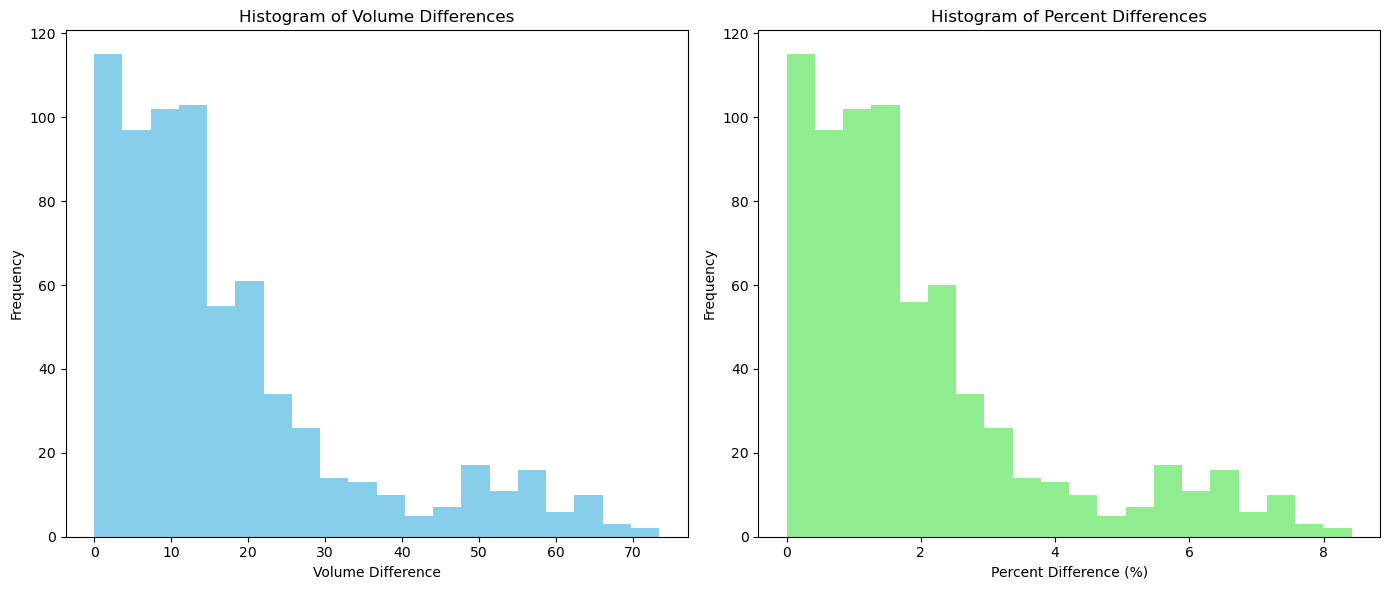

In [34]:
# Separate the differences and percent differences
differences = [data['volume_difference'] for data in comparison_data]
percent_differences = [data['percent_difference'] for data in comparison_data]
#percent_differences = zip(*volume_differences)

# Compute mean and standard deviation
mean_difference = np.mean(differences)
std_deviation = np.std(differences)

print(f"Mean volume difference: {mean_difference}")
print(f"Standard deviation of volume difference: {std_deviation}")

# Plotting
plt.figure(figsize=(14, 6))

# Histogram of volume differences
plt.subplot(1, 2, 1)
plt.hist(differences, bins=20, color='skyblue')
plt.title('Histogram of Volume Differences')
plt.xlabel('Volume Difference')
plt.ylabel('Frequency')

# Histogram of percent differences
plt.subplot(1, 2, 2)
plt.hist(percent_differences, bins=20, color='lightgreen')
plt.title('Histogram of Percent Differences')
plt.xlabel('Percent Difference (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [45]:
from collections import Counter
# I want to plot the composition, and data key of all the structures that have a volume difference greater than 5% 
# I want to see if there is a pattern in the compositions of the structures that have a large volume difference

# Extract keys and composition of structures with volume differences greater than 5%
keys = [data['key'] for data in comparison_data if data['percent_difference'] > 5]
compositions = [[data['perf_composition'], data['vac_composition']] for data in comparison_data if data['percent_difference'] > 5]

formatted_compositions = []
for composition in compositions:
    perf_element_count = Counter(composition[0])
    vac_element_count = Counter(composition[1])
    perf_sorted_elements = sorted(perf_element_count.items(), key=lambda x: x[1], reverse=True)
    vac_sorted_elements = sorted(vac_element_count.items(), key=lambda x: x[1], reverse=True)

    # if the number of unique elements the perfect and vacancy compositions are different, print the formatted_string of both the perfect and vacancy composition
    #if len(perf_sorted_elements) != len(vac_sorted_elements):
    perf_formatted_string = '-'.join([f"{element}:{count}" for element, count in perf_sorted_elements])
    vac_formatted_string = '-'.join([f"{element}:{count}" for element, count in vac_sorted_elements])
    formatted_compositions.append((perf_formatted_string, vac_formatted_string))
    print(f"Perfect: {perf_formatted_string} vs. Vacancy: {vac_formatted_string}")
        #print(f"Vacancy: {vac_formatted_string}")
    print("\n")

    #formatted_string = '-'.join([f"{element}:{count}" for element, count in sorted_elements])
    #print(formatted_string)


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:45-Zr:6-Ti:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:45-Ti:7-Zr:6-Cr:4-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:37-Ti:9-Cr:7-Zr:6-W:4


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:38-Ti:9-Zr:6-Cr:6-W:4


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:38-Ti:9-Cr:7-Zr:5-W:4


Perfect: V:38-Ti:9-Cr:7-Zr:6-W:4 vs. Vacancy: V:37-Ti:9-Cr:7-Zr:6-W:4


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:45-Ti:7-Zr:6-Cr:4-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:45-Ti:7-Zr:6-Cr:5-W:1 vs. Vacancy: V:44-Ti:7-Zr:6-Cr:5-W:1


Perfect: V:48-Ti:8-Zr:4-Cr:3-W:1 vs. Vacancy: V:48-Ti:8-Zr:4-Cr:

In [47]:
import pandas as pd

# Define the compositions
compositions = [
    ('V:45-Ti:7-Zr:6-Cr:5-W:1', 'V:44-Ti:7-Zr:6-Cr:5-W:1'),
    ('V:45-Ti:7-Zr:6-Cr:5-W:1', 'V:45-Zr:6-Ti:6-Cr:5-W:1'),
    # Add all other compositions here
]

# Function to parse the compositions
def parse_composition(composition):
    try:
        elements = composition.split("-")
        return {el.split(":")[0]: int(el.split(":")[1]) for el in elements}
    except IndexError:
        print(f"Error parsing composition: {composition}")
        return {}

# Create a DataFrame
data = []
for perfect, vacancy in compositions:
    perfect_comp = parse_composition(perfect)
    vacancy_comp = parse_composition(vacancy)
    if perfect_comp and vacancy_comp:  # Only append if parsing was successful
        data.append({**perfect_comp, **{'Type': 'Perfect'}})
        data.append({**vacancy_comp, **{'Type': 'Vacancy'}})

df = pd.DataFrame(data)

# Fill missing elements with zeros
elements = ['V', 'Ti', 'Zr', 'Cr', 'W']
df = df.fillna(0)
df = df[elements + ['Type']]

df.head()



,V,Ti,Zr,Cr,W,Type
0,45,7,6,5,1,Perfect
1,44,7,6,5,1,Vacancy
2,45,7,6,5,1,Perfect
3,45,6,6,5,1,Vacancy


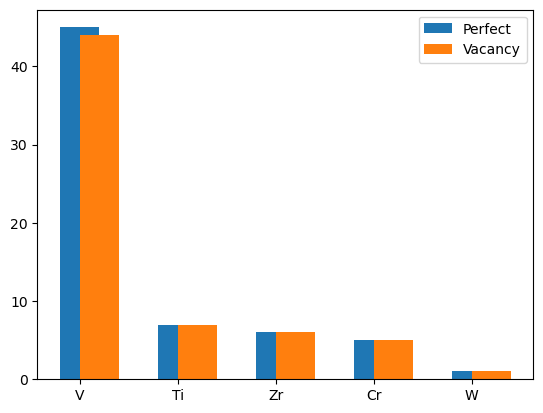

In [48]:
import matplotlib.pyplot as plt

# Function to plot bar charts
def plot_composition_bar(df, index):
    df_perfect = df[df['Type'] == 'Perfect'].iloc[index][:-1]
    df_vacancy = df[df['Type'] == 'Vacancy'].iloc[index][:-1]
    
    labels = df.columns[:-1]
    perfect_vals = df_perfect.values
    vacancy_vals = df_vacancy.values

    x = range(len(labels))

    fig, ax = plt.subplots()
    ax.bar(x, perfect_vals, width=0.4, label='Perfect', align='center')
    ax.bar(x, vacancy_vals, width=0.4, label='Vacancy', align='edge')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

# Plot the first composition pair as an example
plot_composition_bar(df, 0)


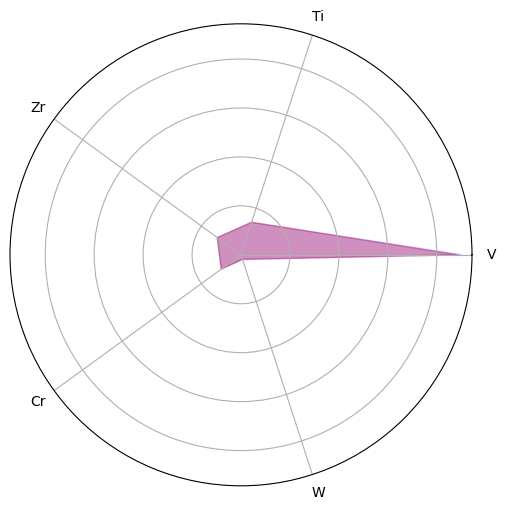

In [49]:
import numpy as np

# Function to plot radar charts
def plot_composition_radar(df, index):
    df_perfect = df[df['Type'] == 'Perfect'].iloc[index][:-1]
    df_vacancy = df[df['Type'] == 'Vacancy'].iloc[index][:-1]
    
    labels = df.columns[:-1]
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    perfect_vals = df_perfect.values.tolist()
    perfect_vals += perfect_vals[:1]
    
    vacancy_vals = df_vacancy.values.tolist()
    vacancy_vals += vacancy_vals[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, perfect_vals, color='blue', alpha=0.25)
    ax.fill(angles, vacancy_vals, color='red', alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.show()

# Plot the first composition pair as an example
plot_composition_radar(df, 0)


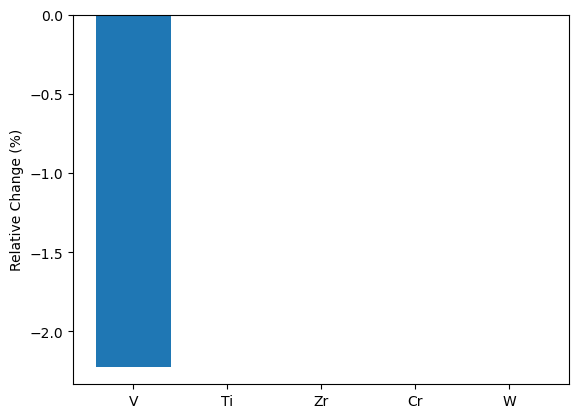

In [50]:
# Function to calculate and plot relative changes
def plot_relative_change(df, index):
    df_perfect = df[df['Type'] == 'Perfect'].iloc[index][:-1]
    df_vacancy = df[df['Type'] == 'Vacancy'].iloc[index][:-1]
    
    relative_change = (df_vacancy - df_perfect) / df_perfect * 100
    labels = df.columns[:-1]
    values = relative_change.values

    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel('Relative Change (%)')
    plt.show()

# Plot the relative change for the first composition pair as an example
plot_relative_change(df, 0)


# Test NEB

In [51]:
# first need to load in a perfect supercell 
structure_info = perfect_data['supercell_gen0_comp11_struct3']['structures'][-1]
perfect_structure = Structure(
        Lattice(structure_info['lattice']), 
        structure_info['species'], 
        structure_info['coords'], 
        coords_are_cartesian=structure_info['coords_are_cartesian'],
        to_unit_cell=structure_info['to_unit_cell']
)

In [53]:
# now i load in the defect maker library and add the ../Modules directory to the path
import sys
sys.path.append('../Modules')
from defect_maker import * 


In [55]:
# now we need to pick a random site from perfect_structure 
site_number = 25 
alat = perfect_structure.lattice.a
nearest_neighbors = return_x_neighbors(structure = perfect_structure, target_atom_index= site_number, x_neighbor=1, alat = alat) 
next_nearest_neighbors = return_x_neighbors(structure = perfect_structure, target_atom_index= site_number, x_neighbor=2, alat = alat)
print(nearest_neighbors)
print(next_nearest_neighbors)

([21, 58, 61, 59, 11, 41, 24, 0], [2.5601652691902177, 2.594451530275561, 2.5964873514189653, 2.599169372266476, 2.668398756895845, 2.6830280281893195, 2.7157403669550395, 2.758557973235984])
([38, 7, 57, 28, 1, 10], [2.98793145108502, 2.997024313140125, 3.01588354734476, 3.125093906107472, 3.1367353510307785, 3.158238031833226])


In [56]:
# now make start and end points
start, end = make_defects(structure = perfect_structure.copy(), target_atom_index= 25, vac_site = 21)

In [78]:
# test interpolate 
from ase.mep import DyNEB 
from ase.optimize import LBFGS 

calculator = NequIPCalculator.from_deployed_model(
        model_path=pot_path,
        species_to_type_name = species,
        device='cuda'
    )
start_atoms = AseAtomsAdaptor.get_atoms(start)
end_atoms = AseAtomsAdaptor.get_atoms(end)
print(start_atoms.get_volume())
print(end_atoms.get_volume())
# relax the start and end points 
#start_atoms.calc = calculator
#end_atoms.calc = calculator
allegro_relaxer(start_atoms, potential_path= pot_path , species = species , device = 'cuda', fmax = 0.05, relax_cell= False)
allegro_relaxer(end_atoms, potential_path= pot_path , species = species , device = 'cuda', fmax = 0.05, relax_cell= False)

images = [start_atoms]
images += [start_atoms.copy() for i in range(5)]
images += [end_atoms]
neb = DyNEB(images, allow_shared_calculator=True)
neb.interpolate(mic=True)
for image in images[1:6]:
    image.calc = calculator 

optimizer = LBFGS(neb)
optimizer.run(fmax=0.05)

872.6688946280925
872.6688946280925
       Step     Time          Energy          fmax
LBFGS:    0 14:58:47     -583.225893        0.934555
LBFGS:    1 14:58:47     -583.286669        0.944503
LBFGS:    2 14:58:48     -583.736550        0.918299
LBFGS:    3 14:58:49     -583.773706        0.847243
LBFGS:    4 14:58:49     -583.929583        0.355117
LBFGS:    5 14:58:49     -583.943901        0.317296
LBFGS:    6 14:58:49     -584.002080        0.340446
LBFGS:    7 14:58:49     -584.040920        0.383070
LBFGS:    8 14:58:49     -584.071750        0.257261
LBFGS:    9 14:58:49     -584.091317        0.270294
LBFGS:   10 14:58:49     -584.099614        0.226726
LBFGS:   11 14:58:49     -584.111381        0.160098
LBFGS:   12 14:58:49     -584.118704        0.125983
LBFGS:   13 14:58:50     -584.122039        0.137102
LBFGS:   14 14:58:50     -584.124317        0.130849
LBFGS:   15 14:58:50     -584.126853        0.084746
LBFGS:   16 14:58:50     -584.128801        0.095881
LBFGS:   17 

True

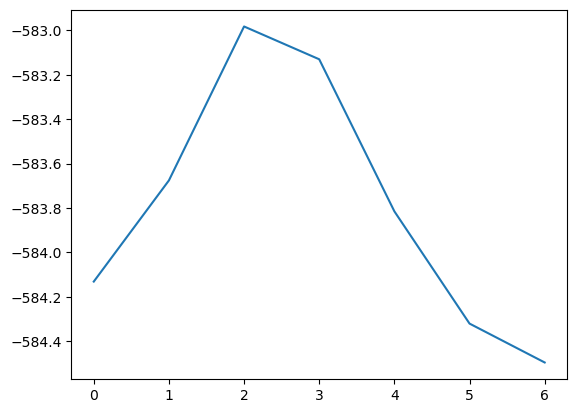

In [79]:
# print the energies of the images
energies = [image.get_potential_energy() for image in images]
images = np.arange(0, 7, 1)
plt.plot(images, energies)
plt.show()

In [71]:
# fully relax the start and end points 
start_relaxed = allegro_relaxer(AseAtomsAdaptor.get_atoms(start), pot_path, species, fmax= 0.05, relax_cell=True)
end_relaxed = allegro_relaxer(AseAtomsAdaptor.get_atoms(end), pot_path, species, fmax = 0.05, relax_cell=True)


       Step     Time          Energy          fmax
LBFGS:    0 14:34:40     -583.225893        0.934555


/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:59: UserWarning: !! Upstream issues in PyTorch versions >1.11 have been seen to cause unusual performance degredations on some CUDA systems that become worse over time; see https://github.com/mir-group/nequip/discussions/311. At present we *strongly* recommend the use of PyTorch 1.11 if using CUDA devices; while using other versions if you observe this problem, an unexpected lack of this problem, or other strange behavior, please post in the linked GitHub issue.
  warnings.warn(
/home/myless/.mambaforge/envs/allegro/lib/python3.10/site-packages/nequip/utils/_global_options.py:103: UserWarning: Do NOT manually set PYTORCH_JIT_USE_NNC_NOT_NVFUSER=0 unless you know exactly what you're doing!
  warnings.warn(


LBFGS:    1 14:34:40     -583.286963        0.944464
LBFGS:    2 14:34:41     -583.739753        0.916891
LBFGS:    3 14:34:41     -583.777160        0.845495
LBFGS:    4 14:34:42     -583.935327        0.355961
LBFGS:    5 14:34:42     -583.950123        0.316473
LBFGS:    6 14:34:42     -584.011073        0.347528
LBFGS:    7 14:34:42     -584.050724        0.392496
LBFGS:    8 14:34:42     -584.083846        0.261388
LBFGS:    9 14:34:42     -584.104298        0.280982
LBFGS:   10 14:34:42     -584.113291        0.236231
LBFGS:   11 14:34:42     -584.126511        0.170015
LBFGS:   12 14:34:42     -584.134877        0.133794
LBFGS:   13 14:34:42     -584.138985        0.153938
LBFGS:   14 14:34:43     -584.142064        0.150802
LBFGS:   15 14:34:43     -584.145765        0.102728
LBFGS:   16 14:34:43     -584.149012        0.123771
LBFGS:   17 14:34:43     -584.151227        0.093265
LBFGS:   18 14:34:43     -584.152911        0.108524
LBFGS:   19 14:34:43     -584.154838        0.

In [75]:
print(AseAtomsAdaptor.get_atoms(start_relaxed['final_structure']).get_volume())
print(AseAtomsAdaptor.get_atoms(end_relaxed['final_structure']).get_volume())

929.9410498699771
782.4107606288998


In [73]:
images = [AseAtomsAdaptor.get_atoms(start_relaxed['final_structure'])]
images += [AseAtomsAdaptor.get_atoms(start_relaxed['final_structure']).copy() for i in range(5)]
images += [AseAtomsAdaptor.get_atoms(end_relaxed['final_structure'])]
neb = DyNEB(images, allow_shared_calculator=True)
neb.interpolate(mic=True)
for image in images[1:6]:
    image.calc = calculator 

optimizer = LBFGS(neb)
optimizer.run(fmax=0.05)

NotImplementedError: Variable cell in periodic directions is not implemented yet for NEB

# Compare AIMD Parameters


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the pickle file
with open('/home/myless/Downloads/dataframes.pkl', 'rb') as f:
    new_dataframes = pickle.load(f)

# Extract temperature data with the ability to specify a starting timestep
def extract_temperature_data(dataframes, start_timestep=50):
    temperature_data = {}
    for name, df in dataframes:
        gamma_value = int(name.split('-')[-1])
        temperatures = df['Temperature'].values[start_timestep:]
        temperature_data[gamma_value] = temperatures
    return temperature_data

# Specify the starting timestep
start_timestep = 50

# Extract temperature data
new_temperature_data = extract_temperature_data(new_dataframes, start_timestep)

# Target temperature
target_temperature = 300

# Initialize a dictionary to hold the new analysis results
new_analysis_results = {}

# Perform the analysis
for gamma, temperatures in new_temperature_data.items():
    mean_temp = np.mean(temperatures)
    std_temp = np.std(temperatures)
    rmsd_temp = np.sqrt(np.mean((temperatures - target_temperature) ** 2))
    
    new_analysis_results[gamma] = {
        'mean': mean_temp,
        'std': std_temp,
        'rmsd': rmsd_temp
    }

# Convert the results to a DataFrame for better visualization
df_new_analysis = pd.DataFrame(new_analysis_results).T
df_new_analysis = df_new_analysis.sort_index()  # Sort by Langevin_gamma_l values

# Save analysis results to CSV file
df_new_analysis.to_csv('new_temperature_analysis_results.csv')

# Plot Mean Temperature
plt.figure(figsize=(10, 6))
plt.plot(df_new_analysis.index, df_new_analysis['mean'], marker='o', label='Mean Temperature')
plt.axhline(target_temperature, color='r', linestyle='--', label='Target Temperature (300 K)')
plt.xlabel('Langevin_gamma_l')
plt.ylabel('Temperature (K)')
plt.title('Mean Temperature vs. Langevin_gamma_l')
plt.legend()
plt.grid(True)
plt.savefig('mean_temperature_plot.png')
plt.close()

# Plot Standard Deviation
plt.figure(figsize=(10, 6))
plt.plot(df_new_analysis.index, df_new_analysis['std'], marker='o', label='Standard Deviation')
plt.xlabel('Langevin_gamma_l')
plt.ylabel('Standard Deviation (K)')
plt.title('Standard Deviation of Temperature vs. Langevin_gamma_l')
plt.legend()
plt.grid(True)
plt.savefig('standard_deviation_plot.png')
plt.close()

# Plot RMSD
plt.figure(figsize=(10, 6))
plt.plot(df_new_analysis.index, df_new_analysis['rmsd'], marker='o', label='RMSD')
plt.xlabel('Langevin_gamma_l')
plt.ylabel('RMSD (K)')
plt.title('RMSD of Temperature vs. Langevin_gamma_l')
plt.legend()
plt.grid(True)
plt.savefig('rmsd_plot.png')
plt.close()
